In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from src.pythonSQL.v2.database_loader_v2 import baseSQL
from matplotlib.transforms import ScaledTranslation
DIR_NAME = "figures/"
connection = create_engine("sqlite:///saves/db_2.db")

/Users/marvinraschke/.local/share/virtualenvs/fishingNN-j66MMPMR/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Loitering events

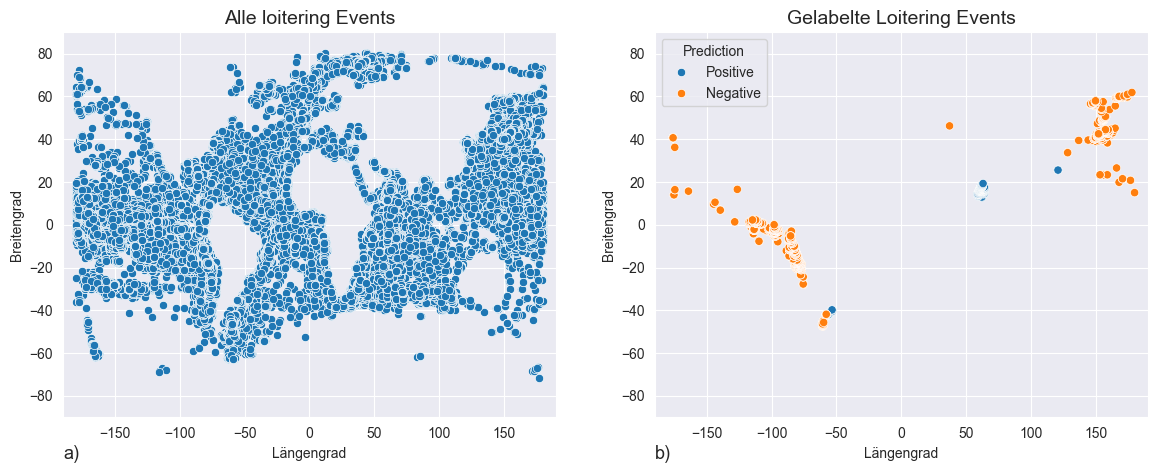

In [2]:
base_sql = baseSQL()
df_loitering_labeled = pd.read_sql(sql=base_sql, con=connection)

sql_all_loitering = """
    SELECT *
    FROM bunker_loitering
    UNION ALL
    SELECT *
    FROM carrier_loitering
"""
df_loitering_all= pd.read_sql(sql=sql_all_loitering, con=connection)

fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(14,5))

sns.scatterplot(df_loitering_all, x="mean_lon", y="mean_lat",ax=axes[0])
sns.scatterplot(df_loitering_labeled, x="mean_lon", y="mean_lat", hue="Prediction" ,ax=axes[1])

for ax in axes:
    ax.set_xlabel("Längengrad")
    ax.set_ylabel("Breitengrad")
    ax.set_xlim(-190,190)
    ax.set_ylim(-90,90)
    
    
axes[0].set_title("Alle loitering Events", fontsize=14)
axes[0].set_title("a)",loc="left",fontsize=13 ,y=-0.13)
axes[1].set_title("Gelabelte Loitering Events",fontsize=14)
axes[1].set_title("b)",loc="left",fontsize=13 ,y=-0.13)


plt.savefig("figures/loitering_events.png")
plt.show()

### Correlation 

In [3]:

sql = baseSQL()
corelation_df_tmp = pd.read_sql(sql=sql, con=connection)
corelation_df_tmp["response"] = corelation_df_tmp['Prediction'].apply(lambda x: 1 if x == 'Positive' else (0 if x == 'Negative' else -1))

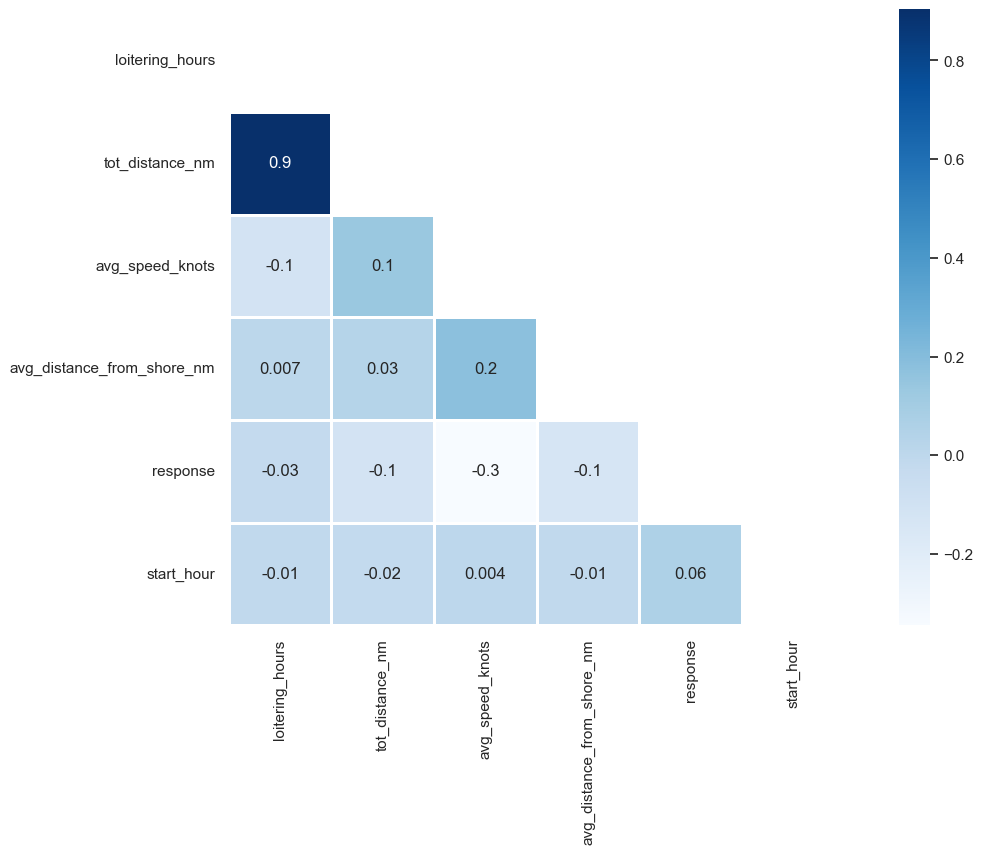

In [4]:
corelation_df_tmp["start_hour"] = pd.to_datetime(corelation_df_tmp["loitering_start_timestamp"]).dt.hour
corelation_df = corelation_df_tmp.drop(["Prediction","mmsi","start_lat","start_lon","end_lat","end_lon","mean_lat","mean_lon","loitering_start_timestamp","loitering_end_timestamp"], axis=1)
correlation = corelation_df.corr(method="pearson")
# print(correlation)
plt.figure(figsize=(14,8))
mask = np.triu(correlation)
sns.set_theme(style="white")
heatmap = sns.heatmap(correlation, mask=mask,square=True ,linewidths=2,annot=True, cmap="Blues", fmt=".1g")
plt.savefig(f"figures/correlation.pdf")
plt.show()

response
0    1893
1     352
Name: count, dtype: int64


<Axes: xlabel='pca1', ylabel='pca2'>

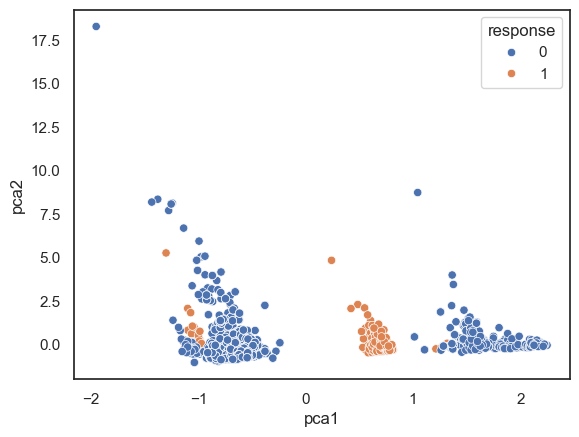

In [12]:
sql = baseSQL()
df = pd.read_sql(sql=sql, con=connection)
df['response'] = df['Prediction'].apply(lambda x: 1 if x == 'Positive' else (0 if x == 'Negative' else -1))
df = df.drop(['mmsi','Prediction','loitering_start_timestamp','loitering_end_timestamp'], axis=1)
scaler = StandardScaler()

y_train = df.pop("response")
X_train = scaler.fit_transform(df)
print(y_train.value_counts())

pca = PCA(3, whiten=True)
PCs = pca.fit_transform(X_train)
pca_df = pd.DataFrame(
    data=PCs,
    columns=["pca1","pca2","pca3"]
)

sns.scatterplot(
    x="pca1", 
    y="pca2", 
    data=pca_df, 
    hue=y_train, 
    legend=True
    )


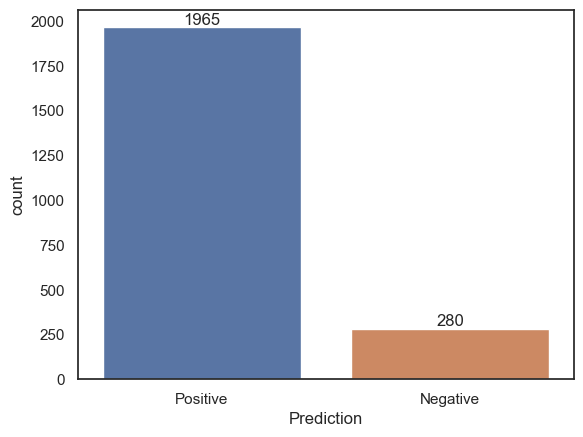

In [7]:
#### Bar Plot Classes
sql = """
    WITH mmsi_pred as (
    Select unlabeld.mmsi, labeld.Prediction
        FROM model_labeld as labeld
        LEFT JOIN model_unlabeld as unlabeld
           USING (hours, fishing_hours, average_daily_fishing_hours,
                  fishing_hours_foreign_eez, fishing_hours_high_seas, distance_traveled_km)
        GROUP BY unlabeld.mmsi, labeld.Prediction
    ),
    mmsi_pred_grouped as (
        SELECT a.*
        FROM mmsi_pred a
        LEFT JOIN (
            SELECT *
            FROM mmsi_pred
            GROUP BY mmsi
            HAVING COUNT(mmsi_pred.mmsi) > 1
        ) b
        on a.mmsi = b.mmsi
        AND  a.Prediction = b.Prediction
        WHERE b.mmsi is NULL
    )
"""
bunker_sql = f"""{sql} 
    SELECT *
    FROM mmsi_pred_grouped
    JOIN bunker_loitering ON bunker_loitering.bunker_mmsi = mmsi_pred_grouped.mmsi
"""
carrier_sql = f"""{sql} 
    SELECT *
    FROM mmsi_pred_grouped
    JOIN carrier_loitering ON carrier_loitering.carrier_mmsi = mmsi_pred_grouped.mmsi
"""
bunker_df = pd.read_sql(sql=bunker_sql, con=connection)
carrier_df = pd.read_sql(sql=carrier_sql, con=connection)

bunker_df["class"] = "Bunker"
carrier_df["class"] = "carrier"

df = pd.concat([bunker_df,carrier_df])
# print(df)
ax = sns.countplot(df, x="Prediction", hue="Prediction", palette="deep")
for container in ax.containers:
    ax.bar_label(container)


plt.savefig(f"figures/verteilung.pdf")
plt.show()

### SVM Kernel

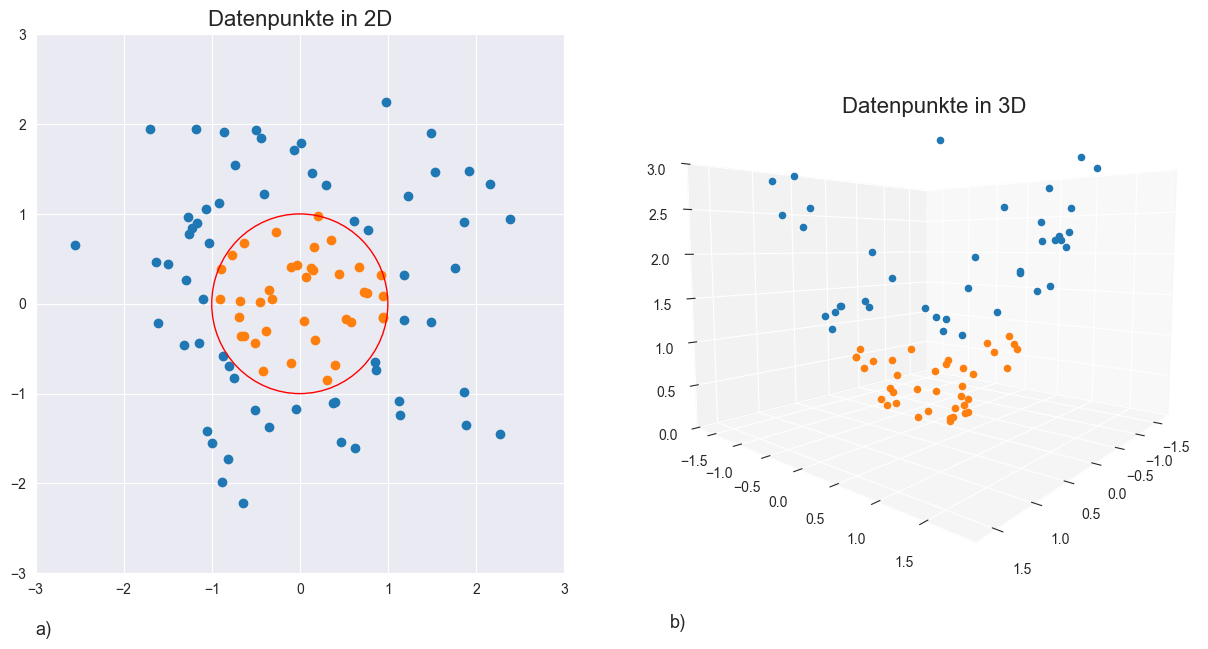

In [9]:
mean = 0
number = 100
scale = 1

# funktion für den Kreis
circle = lambda x: x[:,0]**2 + x[:,1]**2

np.random.seed(0)
x = np.random.normal(mean,scale,size=(number,2)) # wird ein 2D Array
height = circle(x).reshape(-1,1)
x = np.append(x,height,axis=1)
x1= x[circle(x) > 1]
x2= x[circle(x) < 1]


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))

# plot points
ax1.scatter(x1[:,0],x1[:,1])
ax1.scatter(x2[:,0],x2[:,1])
# add circle
center_circle = plt.Circle((0,0),1,fill=False, color="red")
ax1.add_patch(center_circle)
# set limits
ax1.set_xlim(-3,3)
ax1.set_ylim(-3,3)

ax2.remove() # remove the second axis
# inset 3D plot
ax2 = fig.add_subplot(1,2,2,projection="3d")
# set perspective
ax2.set_proj_type('persp', focal_length=0.2)
ax2.view_init(elev=5, azim=40, roll=0)
# remove background
ax2.set_facecolor("none")
# delete points with height > 3
x1 = np.delete(x1, np.where(x1[:,2] > 3), axis=0)
x2 = np.delete(x2, np.where(x2[:,2] > 3), axis=0)
# plot points
ax2.scatter(x1[:,0],x1[:,1],circle(x1), depthshade=False)
ax2.scatter(x2[:,0],x2[:,1],circle(x2), depthshade=False)
# set limits for height of 3d plot
ax2.set_zlim(0,3)

# set labels
ax1.set_title("Datenpunkte in 2D", fontsize=16)
ax1.set_title("a)",loc="left",fontsize=13 ,y=-0.13)
ax2.set_title("Datenpunkte in 3D",fontsize=16)
ax2.set_title("b)",loc="left",fontsize=13 ,y=-0.13)

# save /show figure
plt.savefig(f"figures/svm_kernel.pdf")
plt.show()

### Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

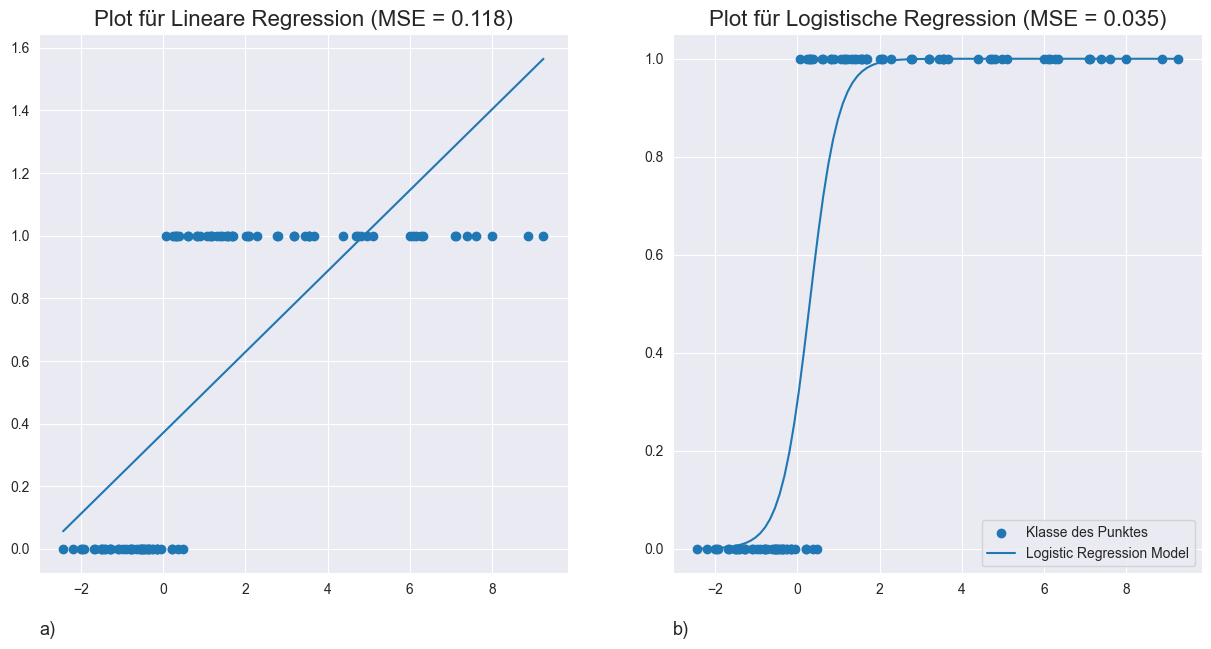

In [74]:
n_samples = 100
np.random.seed(0)
x = np.random.normal(size=n_samples)
y = (x > 0).astype(float)
x[x > 0] *= 4
x += 0.3 * np.random.normal(size=n_samples)

x = x[:, np.newaxis]

prediction_points = np.linspace(np.min(x),np.max(x),100).reshape(-1,1)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))

linear_classifier = LinearRegression()
linear_classifier.fit(x,y)
linear_curve = linear_classifier.predict(prediction_points)
linear_prediction = linear_classifier.predict(x)
linear_MSQ = round(mean_squared_error(y,linear_prediction), 3)
# print(linear_MSQ)
# print(r2_score(y,linear_prediction))

log_classifier = LogisticRegression()
log_classifier.fit(x,y)
log_curve = log_classifier.predict_proba(prediction_points)[:,1]
log_prediction = log_classifier.predict_proba(x)[:,1]
log_MSQ = round(mean_squared_error(y,log_prediction), 3)
# print(log_MSQ)
# print(r2_score(y,log_prediction))



# plot points
ax1.scatter(x,y, label="Klasse des Punktes")
ax1.plot(prediction_points,linear_curve, label="Linear Regression Model")

ax2.scatter(x,y, label="Klasse des Punktes")
ax2.plot(prediction_points,log_curve, label="Logistic Regression Model")


# set labels
ax1.set_title(f"Plot für Lineare Regression (MSE = {linear_MSQ})", fontsize=16)
ax1.set_title("a)",loc="left",fontsize=13 ,y=-0.13)
ax2.set_title(f"Plot für Logistische Regression (MSE = {log_MSQ})",fontsize=16)
ax2.set_title("b)",loc="left",fontsize=13 ,y=-0.13)

plt.legend(loc="lower right")
plt.savefig(f"figures/logistic_regression.pdf")
plt.show()

In [7]:
df_fishing_vessels = pd.read_csv("data/Fishing_Effort/fishing-vessels-v2.csv") 

df_loiter_carrier = pd.read_csv("data/revealing_the_supply_chain_at_sea_2021/carrier_loitering_v20210408.csv")
df_loiter_bunker = pd.read_csv("data/revealing_the_supply_chain_at_sea_2021/bunker_loitering_v20210408.csv")

df_model_raw = pd.read_csv("data/slavery_in_fisheries/s1_training_final.csv")
df_model_labels = pd.read_csv("data/slavery_in_fisheries/s4_final_model_predictions.csv")


In [16]:
# Cleanup data and merge different DataFrames to get the final required dataset
merge_on = ["hours","fishing_hours","average_daily_fishing_hours","fishing_hours_foreign_eez","fishing_hours_high_seas","distance_traveled_km"]
df_model = pd.merge(df_model_raw[merge_on + ["mmsi"]],df_model_labels, on=merge_on, how="right" )
# print(len(df_model)) # bis hier stimmt die Zahl

# https://stackoverflow.com/questions/15222754/groupby-pandas-dataframe-and-select-most-common-value
df_grouped_mmsi = df_model.groupby("mmsi")["Prediction"].apply(pd.Series.mode).reset_index()#.agg(pd.Series.mode).reset_index()
print("mmsi_pred count", len(df_grouped_mmsi))


df_grouped_mmsi = df_grouped_mmsi.drop_duplicates(subset=['mmsi'], keep="last")
df_loiter_data_carrier = pd.merge(df_grouped_mmsi[["mmsi","Prediction"]], df_loiter_carrier, left_on="mmsi", right_on="carrier_mmsi", how="right")
df_loiter_data_bunker = pd.merge(df_grouped_mmsi[["mmsi","Prediction"]], df_loiter_bunker, left_on="mmsi", right_on="bunker_mmsi", how="right")
df_loiter_data = pd.concat([df_loiter_data_carrier,df_loiter_data_bunker])

## Define Class Labeling and encode classes to chosen definitions
IUU_LABEL = 0
NON_IUU_LABEL = 1
UNLABELLED = -1
# Get loiter start hour of day feature. This feature can be useful
df_loiter_data['loitering_start_timestamp'] = pd.to_datetime(df_loiter_data['loitering_start_timestamp'])
df_loiter_data['loitering_start_hour'] = df_loiter_data['loitering_start_timestamp'].dt.hour
df_loiter_data['response'] = df_loiter_data['Prediction'].apply(lambda x: IUU_LABEL if x == 'Positive' else (NON_IUU_LABEL if x == 'Negative' else UNLABELLED))
print("amount:", len(df_loiter_data))
df_loiter_data_unlabeled = df_loiter_data[df_loiter_data['response'] == UNLABELLED].reset_index(drop=True)
df_loiter_data_labeled = df_loiter_data[df_loiter_data['response'] != UNLABELLED].reset_index(drop=True)

# Remove outliers
outliers_labeled = [987]
df_loiter_data_labeled.drop(index=outliers_labeled, inplace=True)

# Extract Relevant columns
rel_cols = ['response','loitering_start_hour','loitering_hours','avg_speed_knots','avg_distance_from_shore_nm']
df_raw_all = df_loiter_data[rel_cols]
df_raw_labeled = df_loiter_data_labeled[rel_cols]
df_raw_unlabeled = df_loiter_data_unlabeled[rel_cols]


mmsi_pred count 16573
amount: 190344
